# k折交叉验证 示例代码

In [ ]:
import numpy as np
from sklearn.model_selection import KFold
import torch
from torch.utils.data import Dataset, DataLoader

# 自定义数据集类
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

# 加载数据
data = ['sample1', 'sample2', 'sample3', 'sample4', 'sample5']
dataset = CustomDataset(data)

# 设置 k 值和随机种子
k = 5
random_state = 42

# 创建 KFold 对象
kf = KFold(n_splits=k, shuffle=True, random_state=random_state)

# 划分数据集
train_indices = []
val_indices = []

for train_index, val_index in kf.split(dataset):
    train_indices.append(train_index)
    val_indices.append(val_index)

# 创建数据加载器
train_loaders = []
val_loaders = []

for fold in range(k):
    train_dataset = torch.utils.data.Subset(dataset, train_indices[fold])
    val_dataset = torch.utils.data.Subset(dataset, val_indices[fold])
    
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    
    train_loaders.append(train_loader)
    val_loaders.append(val_loader)

# 测试运行

## CNN1D_FiledSignal

### LEVEL

In [1]:
import os
import sys
root=os.path.abspath(os.path.join(r"D:\project_meta\NNproject\NNI\notebook\NNITest_0231104.ipynb","../.."))
print(root)
sys.path.append(root)
os.environ["TORCH_HOME"]=r"E:\Data\torch-model"
import warnings  
warnings.filterwarnings("ignore", category=RuntimeWarning, module="mne")
data_root=r'D:\dataset\driver_dataset\DROZY\DROZY'
output_root=r"D:\project_meta\NNproject\NNI\output"

D:\project_meta\NNproject\NNI


## 数据集

In [2]:
import torch
import pandas as pd
from project.dataprocess import FolderTree
from project.dataset.SelfDataset import TableControlFullLoadDataset
from torch.utils.data import DataLoader, Subset, SubsetRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
data_path_dict=FolderTree.getDataPath(data_root=data_root)
output_path_dic=FolderTree.getOutPath(output_root=output_root)

info_table=pd.read_csv(output_path_dic["info_file"])


#随机分配
train_data_table,test_data_table=train_test_split(info_table,test_size=0.2,shuffle=True)

train_dataset=TableControlFullLoadDataset(train_data_table,data_root=data_root,output_root=output_root,Mintime=15)
train_dataloader=DataLoader(train_dataset,batch_size=64,shuffle=True)

test_dataset=TableControlFullLoadDataset(test_data_table,data_root=data_root,output_root=output_root)
test_dataloader=DataLoader(test_dataset,batch_size=512)

In [3]:
from project.model.CNN1D import simple_cnn1d
num_classes=3
cnn=simple_cnn1d(input_channels=5,num_classes=num_classes,list_down=[16,32,64,64,64])
from torchsummary import summary
summary(cnn,(5,7680),batch_size=3,device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [3, 16, 7680]             576
       BatchNorm1d-2              [3, 16, 7680]              32
              ReLU-3              [3, 16, 7680]               0
         MaxPool1d-4              [3, 16, 3839]               0
            Conv1d-5              [3, 32, 1920]           1,568
       BatchNorm1d-6              [3, 32, 1920]              64
              ReLU-7              [3, 32, 1920]               0
            Conv1d-8               [3, 64, 960]           6,208
       BatchNorm1d-9               [3, 64, 960]             128
             ReLU-10               [3, 64, 960]               0
           Conv1d-11               [3, 64, 480]          12,352
      BatchNorm1d-12               [3, 64, 480]             128
             ReLU-13               [3, 64, 480]               0
           Conv1d-14               [3, 

In [4]:
import torch
from d2l import torch as d2l
import torch.nn.functional as F
import datetime
import sklearn as sk
from sklearn.metrics import precision_score, recall_score, f1_score


   
timer, num_batches = d2l.Timer(), len(train_dataloader)

current_time = datetime.datetime.now()
formatted_time = current_time.strftime("%Y_%m_%d_%H_%M_%S")
parameterFolder=os.path.join(r"D:\project_meta\NNproject\NNI\output\model_parameter\FilterSignalCNN1D",f"{formatted_time}")
print(parameterFolder)
os.makedirs(parameterFolder)


D:\project_meta\NNproject\NNI\output\model_parameter\FilterSignalCNN1D\2023_11_07_10_28_02


In [ ]:
device=torch.device("cuda")
num_classes=10
net=simple_cnn1d(input_channels=5,num_classes=num_classes,list_down=[16,32,64,64,64])
net.to(device)


In [9]:
from torch import nn
import torch
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
class Residual1D(nn.Module):  #@save
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv1d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv1d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv1d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm1d(num_channels)
        self.bn2 = nn.BatchNorm1d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)
def resnet_block1d(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual1D(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual1D(num_channels, num_channels))
    return blk
featureNum=5
b1OutChannel=64
b2OutChannel=64
b3OutChannel=128
b4OutChannel=256
b5OutChannel=512
classNum=10
b1 = nn.Sequential(nn.Conv1d(featureNum, b1OutChannel, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm1d(64), nn.ReLU(),
                   nn.MaxPool1d(kernel_size=3, stride=2, padding=1))
b2 = nn.Sequential(*resnet_block1d(b1OutChannel,b2OutChannel, 2, first_block=True))
b3 = nn.Sequential(*resnet_block1d(b2OutChannel, b3OutChannel, 2))
b4 = nn.Sequential(*resnet_block1d(b3OutChannel, b4OutChannel, 2))
b5 = nn.Sequential(*resnet_block1d(b4OutChannel, b5OutChannel, 2))
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool1d((1)),
                    nn.Flatten(), nn.Linear(b5OutChannel,classNum))
summary(net,(featureNum,7680),batch_size=3,device='cpu')
device=torch.device("cuda")
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool1d((1)),
                    nn.Flatten(), nn.Linear(b5OutChannel,classNum)).to(device)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [3, 64, 3840]           2,304
       BatchNorm1d-2              [3, 64, 3840]             128
              ReLU-3              [3, 64, 3840]               0
         MaxPool1d-4              [3, 64, 1920]               0
            Conv1d-5              [3, 64, 1920]          12,352
       BatchNorm1d-6              [3, 64, 1920]             128
            Conv1d-7              [3, 64, 1920]          12,352
       BatchNorm1d-8              [3, 64, 1920]             128
        Residual1D-9              [3, 64, 1920]               0
           Conv1d-10              [3, 64, 1920]          12,352
      BatchNorm1d-11              [3, 64, 1920]             128
           Conv1d-12              [3, 64, 1920]          12,352
      BatchNorm1d-13              [3, 64, 1920]             128
       Residual1D-14              [3, 6

KeyboardInterrupt: 

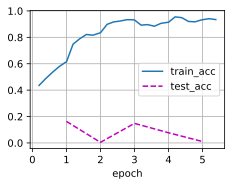

In [10]:
optim=torch.optim.SGD(net.parameters(),lr=0.05,weight_decay=5e-4)
loss=torch.nn.CrossEntropyLoss().to(device="cuda")


num_epochs=2000
best_train_acc=0
best_train_loss=0
best_test_acc=0
stagnate_times=0
temp_acc=0
animator = d2l.Animator(xlabel='epoch',
                        legend=['train_acc','test_acc'])
for epoch in range(num_epochs):
    metric_train = d2l.Accumulator(2)
    net.train()
    for i,data_dict in enumerate(train_dataloader):
        optim.zero_grad()
        x=data_dict["data"].to(torch.float32).to(device)
        x=x+torch.randn_like(x).to(device) /100        
        y=data_dict["KSS"].long().to(device)-1
        y_hat=net(x)
        l=F.cross_entropy(y_hat, y)
        l.mean().backward()
        optim.step()     
        pre=torch.argmax(y_hat.detach().cpu(),dim=1)
        num_true=sum(pre==y.cpu())
        metric_train.add(num_true,y.numel())
        if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
            animator.add(epoch + (i + 1) / num_batches, (metric_train[0]/metric_train[1],None))
    
    net.eval()
    metric_test = d2l.Accumulator(2)
    for data_dict in test_dataloader:
        x=data_dict["data"].to(torch.float32).to(device)
        y=data_dict["KSS"].long().to(device)
        y_hat=net(x)
        pre=torch.argmax(y_hat.detach().cpu(),dim=1)
        num_true=sum(pre==y.cpu())
        metric_test.add(num_true,y.numel())
    animator.add(epoch+ 1, (None,metric_test[0]/metric_test[1]))
    
    stagnate_times=stagnate_times+1
    if best_test_acc<(metric_test[0]/metric_test[1]):
        best_test_acc=metric_test[0]/metric_test[1]
        stagnate_times=0
        torch.save(net.state_dict(),os.path.join(parameterFolder,f'{best_test_acc}.pt'))
    if temp_acc<metric_test[0]/metric_test[1]:
        stagnate_times=0 
    temp_acc= metric_test[0]/metric_test[1]          
    if stagnate_times>20:
        break

<Axes: >

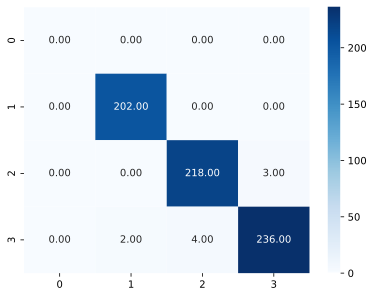

In [29]:
from sklearn.metrics import confusion_matrix
import numpy as np
num_classes=4
confusion_matrix_test = np.zeros((num_classes, num_classes))
net.load_state_dict(torch.load(r"D:\project_meta\NNproject\NNI\output\model_parameter\FilterSignalCNN1D\2023_11_06_13_46_24\0.9909774436090225.pt"))
for data_dict in test_dataloader:
    x=data_dict["data"].to(torch.float32).to(device)
    y=data_dict["LEVEL"].long().to(device)
    y_hat=net(x)
    pre=torch.argmax(y_hat.detach().cpu(),dim=1)
    num_true=sum(pre==y.cpu())
    y_pred = torch.stack((pre, y.cpu()), dim=1)
    confusion_matrix_test += confusion_matrix(y_pred[:, 1], y_pred[:, 0], labels=range(num_classes))
import seaborn as sns
sns.heatmap(confusion_matrix_test,annot=True, fmt=".2f", cmap="Blues")


### KSS

In [ ]:
import os
import sys
root=os.path.abspath(os.path.join(r"D:\project_meta\NNproject\NNI\notebook\NNITest_0231104.ipynb","../.."))
print(root)
sys.path.append(root)
os.environ["TORCH_HOME"]=r"E:\Data\torch-model"
import warnings  
warnings.filterwarnings("ignore", category=RuntimeWarning, module="mne")
data_root=r'D:\dataset\driver_dataset\DROZY\DROZY'
output_root=r"D:\project_meta\NNproject\NNI\output"

D:\project_meta\NNproject\NNI


In [ ]:
import torch
import pandas as pd
from project.dataprocess import FolderTree
from project.dataset.SelfDataset import TableControlFullLoadDataset
from torch.utils.data import DataLoader, Subset, SubsetRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
data_path_dict=FolderTree.getDataPath(data_root=data_root)
output_path_dic=FolderTree.getOutPath(output_root=output_root)

info_table=pd.read_csv(output_path_dic["info_file"])
train_data_table,test_data_table=train_test_split(info_table,test_size=0.2,shuffle=False)

train_dataset=TableControlFullLoadDataset(train_data_table,data_root=data_root,output_root=output_root,Mintime=15)
train_dataloader=DataLoader(train_dataset,batch_size=64)

test_dataset=TableControlFullLoadDataset(test_data_table,data_root=data_root,output_root=output_root)
test_dataloader=DataLoader(test_dataset,batch_size=512)

In [ ]:
from project.model.CNN1D import simple_cnn1d
num_classes=10
cnn=simple_cnn1d(input_channels=5,num_classes=num_classes,list_down=[16,32,64,64,64])
from torchsummary import summary
summary(cnn,(5,3*2560),batch_size=3,device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [3, 16, 7680]             576
       BatchNorm1d-2              [3, 16, 7680]              32
              ReLU-3              [3, 16, 7680]               0
         MaxPool1d-4              [3, 16, 3839]               0
            Conv1d-5              [3, 32, 1920]           1,568
       BatchNorm1d-6              [3, 32, 1920]              64
              ReLU-7              [3, 32, 1920]               0
            Conv1d-8               [3, 64, 960]           6,208
       BatchNorm1d-9               [3, 64, 960]             128
             ReLU-10               [3, 64, 960]               0
           Conv1d-11               [3, 64, 480]          12,352
      BatchNorm1d-12               [3, 64, 480]             128
             ReLU-13               [3, 64, 480]               0
           Conv1d-14               [3, 

D:\project_meta\NNproject\NNI\output\model_parameter\FilterSignalCNN1D\2023_11_06_10_26_05


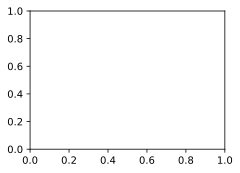

In [ ]:
import torch
from d2l import torch as d2l
import torch.nn.functional as F
import datetime
import sklearn as sk
from sklearn.metrics import precision_score, recall_score, f1_score
device=torch.device("cuda")
device
net=cnn
net.to(device)

optim=torch.optim.SGD(net.parameters(),lr=0.05,weight_decay=5e-4)
loss=torch.nn.CrossEntropyLoss().to(device="cuda")
num_epochs=500
animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                        legend=['train_acc','test_acc'])   

timer, num_batches = d2l.Timer(), len(train_dataloader)
best_train_acc=0
best_train_loss=0

best_test_acc=0

stagnate_times=0

current_time = datetime.datetime.now()
formatted_time = current_time.strftime("%Y_%m_%d_%H_%M_%S")
parameterFolder=os.path.join(r"D:\project_meta\NNproject\NNI\output\model_parameter\FilterSignalCNN1D",f"{formatted_time}")
print(parameterFolder)
os.makedirs(parameterFolder)



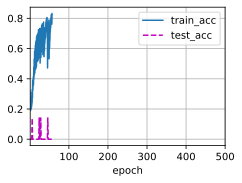

In [ ]:

for epoch in range(num_epochs):
    metric_train = d2l.Accumulator(2)
    net.train()
    for i,data_dict in enumerate(train_dataloader):
        optim.zero_grad()
        x=data_dict["data"].to(torch.float32).to(device)     
        y=data_dict["LEVEL"].long().to(device)
        y_hat=net(x)
        l=F.cross_entropy(y_hat, y)
        l.mean().backward()
        optim.step()     
        pre=torch.argmax(y_hat.detach().cpu(),dim=1)
        num_true=sum(pre==y.cpu())
        metric_train.add(num_true,y.numel())
        if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
            animator.add(epoch + (i + 1) / num_batches, (metric_train[0]/metric_train[1],None))
    
    net.eval()
    metric_test = d2l.Accumulator(2)
    for data_dict in test_dataloader:
        x=data_dict["data"].to(torch.float32).to(device)
        y=data_dict["KSS"].long().to(device)
        y_hat=net(x)
        pre=torch.argmax(y_hat.detach().cpu(),dim=1)
        num_true=sum(pre==y.cpu())
        metric_test.add(num_true,y.numel())
    animator.add(epoch+ 1, (None,metric_test[0]/metric_test[1]))
    
    if best_test_acc<=(metric_test[0]/metric_test[1]):
        best_test_acc=metric_test[0]/metric_test[1]
        stagnate_times=0      
        torch.save(net.state_dict(),os.path.join(parameterFolder,f'{best_test_acc}.pt'))
    else:
        stagnate_times=stagnate_times+1
    
    
    if stagnate_times>50:
        break

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
num_classes=10
confusion_matrix_test = np.zeros((num_classes, num_classes))
net.load_state_dict(torch.load(r"D:\project_meta\NNproject\NNI\output\model_parameter\FilterSignalCNN1D\2023_11_06_09_39_39\0.6124148372445117.pt"))
for data_dict in test_dataloader:
    x=data_dict["data"].to(torch.float32).to(device)
    y=data_dict["LEVEL"].long().to(device)
    y_hat=net(x)
    pre=torch.argmax(y_hat.detach().cpu(),dim=1)
    num_true=sum(pre==y.cpu())
    y_pred = torch.stack((pre, y.cpu()), dim=1)
    confusion_matrix_test += confusion_matrix(y_pred[:, 1], y_pred[:, 0], labels=range(num_classes))


## K折交叉验证

### 设置路径

In [1]:
import os
import sys
root=os.path.abspath(os.path.join(r"D:\project_meta\NNproject\NNI\notebook\NNITest_0231104.ipynb","../.."))
print(root)
sys.path.append(root)
os.environ["TORCH_HOME"]=r"E:\Data\torch-model"
import warnings  
warnings.filterwarnings("ignore", category=RuntimeWarning, module="mne")
data_root=r'D:\dataset\driver_dataset\DROZY\DROZY'
output_root=r"D:\project_meta\NNproject\NNI\output"

D:\project_meta\NNproject\NNI


### 数据集准备

In [5]:
import torch
import pandas as pd
from project.dataprocess import FolderTree
from project.dataset.SelfDataset import TableControlFullLoadDataset
from torch.utils.data import DataLoader, Subset, SubsetRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from d2l import torch as d2l

data_path_dict=FolderTree.getDataPath(data_root=data_root)
output_path_dic=FolderTree.getOutPath(output_root=output_root)

info_table=pd.read_csv(output_path_dic["info_file"])
dataset=TableControlFullLoadDataset(info_table,data_root=data_root,output_root=output_root,Mintime=15)


In [6]:
from project.model.CNN1D import simple_cnn1d
num_classes=4
cnn=simple_cnn1d(input_channels=5,num_classes=num_classes,list_down=[16,32,64,64,64])
from torchsummary import summary
summary(cnn,(5,3*2560),batch_size=3,device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [3, 16, 7680]             576
       BatchNorm1d-2              [3, 16, 7680]              32
              ReLU-3              [3, 16, 7680]               0
         MaxPool1d-4              [3, 16, 3839]               0
            Conv1d-5              [3, 32, 1920]           1,568
       BatchNorm1d-6              [3, 32, 1920]              64
              ReLU-7              [3, 32, 1920]               0
            Conv1d-8               [3, 64, 960]           6,208
       BatchNorm1d-9               [3, 64, 960]             128
             ReLU-10               [3, 64, 960]               0
           Conv1d-11               [3, 64, 480]          12,352
      BatchNorm1d-12               [3, 64, 480]             128
             ReLU-13               [3, 64, 480]               0
           Conv1d-14               [3, 

D:\project_meta\NNproject\NNI\output\model_parameter\FilterSignalCNN1D\2023_11_06_15_34_30


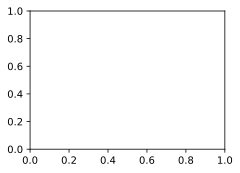

In [7]:
import torch
from d2l import torch as d2l
import torch.nn.functional as F
import datetime
import sklearn as sk
from sklearn.metrics import precision_score, recall_score, f1_score
from project.model.CNN1D import simple_cnn1d
device=torch.device("cuda")
device
net=simple_cnn1d(input_channels=5,num_classes=num_classes,list_down=[16,32,64,64,64])
net.to(device)

optim=torch.optim.SGD(net.parameters(),lr=0.05,weight_decay=5e-4)
loss=torch.nn.CrossEntropyLoss().to(device="cuda")
num_epochs=2000
animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                        legend=['train_acc','test_acc'])   

timer = d2l.Timer()
best_train_acc=0
best_train_loss=0

best_test_acc=0

stagnate_times=0

current_time = datetime.datetime.now()
formatted_time = current_time.strftime("%Y_%m_%d_%H_%M_%S")
parameterFolder=os.path.join(r"D:\project_meta\NNproject\NNI\output\model_parameter\FilterSignalCNN1D",f"{formatted_time}")
print(parameterFolder)
os.makedirs(parameterFolder)


In [9]:
# from sklearn.model_selection import KFold
# kf = KFold(n_splits=10, shuffle=True, random_state=0)
# a,b=next(iter(kf.split(dataset)))
# print(a.shape,b.shape)
# train_fold = torch.utils.data.dataset.Subset(dataset, a)
# len(train_fold)

KeyboardInterrupt: 

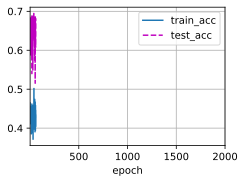

In [8]:
from sklearn.model_selection import KFold
 
kf = KFold(n_splits=10, shuffle=False)
AnimatorList=[]
for  i,(train_index, val_index) in enumerate(kf.split(dataset)):
    # print(train_index, test_index)
    AnimatorList.append( d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                        legend=['train_acc','test_acc']))
    animator=AnimatorList[i]
    train_fold = torch.utils.data.dataset.Subset(dataset, train_index)
    val_fold = torch.utils.data.dataset.Subset(dataset, val_index)    
    
    # 打包成DataLoader类型 用于 训练
    train_loader = DataLoader(dataset=train_fold, batch_size=16, shuffle=True)
    val_loader = DataLoader(dataset=val_fold, batch_size=16, shuffle=True)
    train_size = len(train_loader)
    val_size = len(val_loader)
    num_batches=len(train_loader)
    train_dataloader=train_loader
    test_dataloader=val_loader
    # 开始进行训练
    best_train_acc=0
    best_train_loss=0
    best_test_acc=0
    stagnate_times=0

    #初始化
    net=simple_cnn1d(input_channels=5,num_classes=num_classes,list_down=[16,32,64,64,64])
    net.to(device)
    print("训练开始.....")
    for epoch in range(num_epochs):
        metric_train = d2l.Accumulator(2)
        net.train()
        for i,data_dict in enumerate(train_dataloader):
            optim.zero_grad()
            x=data_dict["data"].to(torch.float32).to(device)     
            y=data_dict["LEVEL"].long().to(device)
            y_hat=net(x)
            l=F.cross_entropy(y_hat, y)
            l.mean().backward()
            optim.step()     
            pre=torch.argmax(y_hat.detach().cpu(),dim=1)
            num_true=sum(pre==y.cpu())
            metric_train.add(num_true,y.numel())
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches, (metric_train[0]/metric_train[1],None))
        net.eval()
        metric_test = d2l.Accumulator(2)
        for data_dict in test_dataloader:
            x=data_dict["data"].to(torch.float32).to(device)
            y=data_dict["LEVEL"].long().to(device)
            y_hat=net(x)
            pre=torch.argmax(y_hat.detach().cpu(),dim=1)
            num_true=sum(pre==y.cpu())
            metric_test.add(num_true,y.numel())
        animator.add(epoch+ 1, (None,metric_test[0]/metric_test[1]))
        
        if best_test_acc<(metric_test[0]/metric_test[1]):
            best_test_acc=metric_test[0]/metric_test[1]
            stagnate_times=0
            
            
            torch.save(net.state_dict(),os.path.join(parameterFolder,f'{i}_{best_test_acc}.pt'))
        else:
            stagnate_times=stagnate_times+1
        
        if stagnate_times>50:
            break

In [41]:
for  i,(train_index, val_index) in enumerate(kf.split(dataset)):
    print(i)

0
1
2
3
4
5
6
7
8
9


<Axes: >

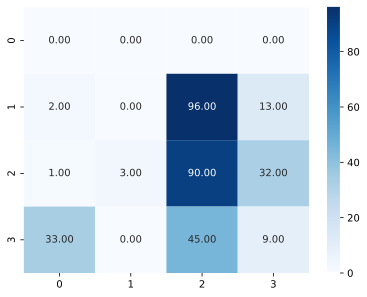

In [37]:
from sklearn.metrics import confusion_matrix
import numpy as np
num_classes=4
confusion_matrix_test = np.zeros((num_classes, num_classes))
net.load_state_dict(torch.load(r"D:\project_meta\NNproject\NNI\output\model_parameter\FilterSignalCNN1D\2023_11_06_14_04_11\0.6697530864197531.pt"))
for data_dict in test_dataloader:
    x=data_dict["data"].to(torch.float32).to(device)
    y=data_dict["LEVEL"].long().to(device)
    y_hat=net(x)
    pre=torch.argmax(y_hat.detach().cpu(),dim=1)
    num_true=sum(pre==y.cpu())
    y_pred = torch.stack((pre, y.cpu()), dim=1)
    confusion_matrix_test += confusion_matrix(y_pred[:, 1], y_pred[:, 0], labels=range(num_classes))
import seaborn as sns
sns.heatmap(confusion_matrix_test,annot=True, fmt=".2f", cmap="Blues")